In [9]:
from json import load
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.ndimage import label

from collections import deque

DIRPATH = '../maps/example_maps_odom_v6_003_waffle_counter_clockwise'
MAP_001 = 'map_20250330_222348_568341.json'

VAL_UNKNOWN = -1
VAL_FREE = 0
VAL_OCCUPIED = 100
VAL_INACCESSIBLE = 101

VAL_CURR_POSITION = 200
VAL_NEXT_GOAL = 201

VAL_ESTIMATED_WALL = 250

colormap = {
    VAL_UNKNOWN: [0.5, 0.5, 0.5],  # Gray (unknown terrain)
    VAL_FREE: [1.0, 1.0, 1.0],  # White (blank space)
    VAL_OCCUPIED: [0.0, 0.0, 0.0],  # Black (walls)
    VAL_INACCESSIBLE: [0.0, 1.0, 0.0],  # Green (estimated walls)
    
    VAL_CURR_POSITION: [1.0, 0.0, 0.0],  # Red (current position)
    VAL_NEXT_GOAL: [0.0, 0.0, 1.0],  # Blue (next goal)
    VAL_ESTIMATED_WALL: [1.0, 0.5, 0.0],  # Orange (estimated walls)
}

RESOLUTION = 0.03  # meters per pixel


## Input and output

In [10]:
def read_data_map(_dir_path: str=DIRPATH, _map_path: str=MAP_001) -> tuple[np.ndarray[tuple[()], np.dtype], float, float]:
    """Reads map data from a JSON file and returns the grid, origin x, and origin y.
    Args:
        _dir_path (str, optional): Directory path to the map file. Defaults to DIRPATH.
        _map_path (str, optional): Map file name. Defaults to MAP_001.

    Returns:
        _type_: _description_
    """
    
    _data = dict()
    with open(_dir_path + '/' + _map_path, 'r+') as json_data:
        _data = load(json_data)
        json_data.close()
    
    try:
        _data = _data['map']
        print(_data)

        width = _data['info']['width']
        height = _data['info']['height']
        origin_x = _data['info']['origin']['position']['x']
        origin_y = _data['info']['origin']['position']['y']
        _data = _data['data']

        grid = np.array(_data).reshape((height, width))

        return grid, origin_x, origin_y

    except:
        print('No data found in the map file')
    
    return None, None, None

def read_data_odom(_dir_path: str=DIRPATH, _odom_path: str=MAP_001) -> tuple[int, int]:
    _data = dict()
    with open(_dir_path + '/' + _odom_path, 'r+') as json_data:
        _data = load(json_data)
        json_data.close()
    
    try:
        _data = _data['odom']
        print(_data)

        x = _data['pose']['pose']['position']['x']
        y = _data['pose']['pose']['position']['y']

        return x, y

    except:
        print('No data found in the odom file')
    
    return None, None
    

def print_plot_v2(
    grid: np.ndarray[tuple[()], np.dtype],
    title: str="Original map",
    filename: str="Not provided",
    occupied: int=-1,
    free: int=-1,
    inaccessible: int=-1,
    unknown: int=-1,
    explored_percent: float=-1.0,
    position_x: float=-1,
    position_y: float=-1) -> None:
    height, width = grid.shape
    colored_map = np.zeros((height, width, 3))

    for y in range(height):
        for x in range(width):
            color_code = grid[y, x]
            colored_map[y, x] = colormap[color_code]
            
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(colored_map, origin='upper')
    plt.title(title)
    plt.axis('off')
    
    legend_text = (f"Filename: {filename}\n"
                   f"Occupied: {occupied}\n"
                   f"Free: {free}\n"
                   f"Inaccessible: {inaccessible}\n"
                   f"Unknown: {unknown}\n"
                   f"Explored: {100*explored_percent:.8f}\n"
                   f"Position: {position_x:.4f}, {position_y:.4f}"
                   )
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.text(0.1, 0.5, legend_text, fontsize=12, verticalalignment='center')
    
    plt.show()
    
    return

## Space estimation

In [11]:
def get_reachable_mask(grid: np.ndarray, position: tuple[int, int]) -> np.ndarray[tuple[()], np.dtype]:
    h, w = grid.shape
    visited = np.zeros_like(grid, dtype=bool)
    q = deque([position])
    visited[position[1], position[0]] = True
    
    while q:
        x, y = q.popleft()
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < w and 0 <= ny < h:
                if not visited[ny, nx] and grid[ny, nx] in [0, -1]:
                    visited[ny, nx] = True
                    q.append((nx, ny))

    return visited


In [12]:
def fill_outside_with_val_inaccessible(grid: np.ndarray, position: tuple[int, int]) -> np.ndarray[tuple[()], np.dtype]:
    reachable = get_reachable_mask(grid, position)
    grid[(grid == -1) & (~reachable)] = VAL_INACCESSIBLE
    
    return grid

def is_fully_enclosed(grid: np.ndarray, position: tuple[int, int]) -> bool:
    reachable = get_reachable_mask(grid, position)
    unknown_mask = (grid == -1)
    
    return not np.any(reachable & unknown_mask)

def fill_enclosed_unknowns_v2(grid: np.ndarray, position: tuple[int, int]) -> np.ndarray[tuple[()], np.dtype]:
    reachable = get_reachable_mask(grid, position)
    unknown = (grid == -1)
    enclosed = unknown & (~reachable)
    grid[enclosed] = VAL_INACCESSIBLE
    
    return grid

def fill_boundary_unknowns(grid: np.ndarray, position: tuple[int, int]) -> np.ndarray[tuple[()], np.dtype]:
    reachable = get_reachable_mask(grid, position)
    h, w = grid.shape
    for y in range(h):
        for x in range(w):
            if grid[y, x] == -1 and reachable[y, x]:
                neighbors = [(x+dx, y+dy) for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]]
                if any(0 <= nx < w and 0 <= ny < h and grid[ny, nx] == 0 for nx, ny in neighbors):
                    grid[y, x] = 0
    
    return grid

def fill_boundary_gaps(grid: np.ndarray, position: tuple[int, int]) -> np.ndarray[tuple[()], np.dtype]:
    reachable = get_reachable_mask(grid, position)
    h, w = grid.shape
    for y in range(h):
        for x in range(w):
            if grid[y, x] == -1 and reachable[y, x]:
                neighbors = [(x+dx, y+dy) for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]]
                free_neighbors = [grid[ny, nx] == 0 for nx, ny in neighbors if 0 <= nx < w and 0 <= ny < h]
                if sum(free_neighbors) >= 2:
                    grid[y, x] = 0
    
    return grid


In [13]:
def calculate_remaining_space(grid: np.ndarray[tuple[()], np.dtype]) -> tuple:

    _explored_num = np.count_nonzero(grid==VAL_OCCUPIED) + np.count_nonzero(grid==VAL_FREE) + np.count_nonzero(grid==VAL_INACCESSIBLE)
    _height, _width = grid.shape
    # print(_width, _height, _width*_height, _explored_num)
    _explored_percent = _explored_num / (_width * _height)
    print('explored %f not explored %f', _explored_percent, 1.0-_explored_percent)
    
    return np.count_nonzero(grid==VAL_OCCUPIED),\
        np.count_nonzero(grid==VAL_FREE),\
        np.count_nonzero(grid==VAL_INACCESSIBLE),\
        np.count_nonzero(VAL_UNKNOWN),\
        _explored_percent

## Exploration

In [14]:
def get_position(x: float, y: float, origin_x: float = 0.0, origin_y: float = 0.0) -> tuple[int, int]:
    """Get position in pixels from real-world coordinates.

    Args:
        x (float), y (float): Real-world coordinates to mark.
        origin_x (float, optional), origin_y (float, optional): Real-world coordinates of the map's origin (bottom-left corner). Defaults to 0.0.

    Returns:
        tuple: position x and y in pixels
    """
    
    return int((x - origin_x) / RESOLUTION), int((y - origin_y) / RESOLUTION)

def mark_position(
    grid: np.ndarray,
    x: float,
    y: float,
    origin_x: float = 0.0,
    origin_y: float = 0.0
    ) -> np.ndarray:
    """
    Marks a position on the grid based on real-world coordinates and map origin.

    Args:
        grid: 2D numpy array representing the map.
        x, y: Real-world coordinates to mark.
        origin_x, origin_y: Real-world coordinates of the map's origin (bottom-left corner).

    Returns:
        Modified grid with the position marked.
    """
    height, width = grid.shape

    # Convert world coordinates to pixel indices
    x_pixel, y_pixel = get_position(x, y, origin_x, origin_y)

    print(f"Marking position at world coordinates: ({x}, {y})")
    print(f"Converted to pixel coordinates: ({x_pixel}, {y_pixel})")

    if 0 <= x_pixel < width and 0 <= y_pixel < height:
        grid[y_pixel, x_pixel] = VAL_CURR_POSITION
    else:
        print("Warning: Position out of grid bounds.")

    return grid

def mark_position_v2(
    grid: np.ndarray,
    x: int,
    y: int,
    color: int = VAL_CURR_POSITION
    ) -> np.ndarray:
    """
    Marks a position on the grid based on real-world coordinates and map origin.

    Args:
        grid: 2D numpy array representing the map.
        x, y: grid coordinates.

    Returns:
        Modified grid with the position marked.
    """
    height, width = grid.shape

    print(f"Marking position at world coordinates: ({x}, {y})")

    if 0 <= x < width and 0 <= y < height:
        grid[y, x] = color
    else:
        print("Warning: Position out of grid bounds.")

    return grid


In [15]:
def explore_nearest_unknown(
    grid: np.ndarray,
    x: float,
    y: float,
    origin_x: float = 0.0,
    origin_y: float = 0.0,
    resolution: float = 1.0
) -> tuple[float | None, float | None, int | None, int | None]:
    """
    Navigate to the nearest unknown (-1) cell.

    Parameters:
        grid (np.ndarray): Occupancy grid (2D)
        x (float): Robot real-world x position
        y (float): Robot real-world y position
        origin_x (float): Map origin x in real-world coordinates
        origin_y (float): Map origin y in real-world coordinates
        resolution (float): Map resolution (m/cell)

    Returns:
        Tuple of real-world coordinates (x, y) and grid coordinates (x, y) or None if no unknowns found
    """
    height, width = grid.shape

    # Convert real-world position to grid indices
    grid_x = int((x - origin_x) / resolution)
    grid_y = int((y - origin_y) / resolution)

    # Validate bounds
    if not (0 <= grid_x < width and 0 <= grid_y < height):
        raise ValueError("Robot position is out of map bounds")

    # Find all unknown cells
    unknown_indices = np.argwhere(grid == -1)
    if unknown_indices.size == 0:
        return None, None, None, None

    # Compute distances
    distances = np.linalg.norm(unknown_indices - np.array([grid_y, grid_x]), axis=1)
    nearest_idx = unknown_indices[np.argmin(distances)]

    # Convert grid indices back to real-world coordinates
    target_real_x = origin_x + nearest_idx[1] * resolution + resolution / 2
    target_real_y = origin_y + nearest_idx[0] * resolution + resolution / 2

    return (target_real_x, target_real_y, nearest_idx[1], nearest_idx[0])

# copilot generated for fun - will not be used
def get_wall_estimation(grid: np.ndarray, position: tuple[int, int]) -> np.ndarray[tuple[()], np.dtype]:
    h, w = grid.shape
    visited = np.zeros_like(grid, dtype=bool)
    q = deque([position])
    visited[position[1], position[0]] = True
    
    while q:
        x, y = q.popleft()
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < w and 0 <= ny < h:
                if not visited[ny, nx] and grid[ny, nx] == VAL_UNKNOWN:
                    visited[ny, nx] = True
                    q.append((nx, ny))

    return visited


## Try to combine elements together

{'header': {'stamp': {'sec': 1, 'nanosec': 914000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 133, 'height': 170, 'origin': {'position': {'x': -2.9276428053780297, 'y': -2.5529621305117147, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

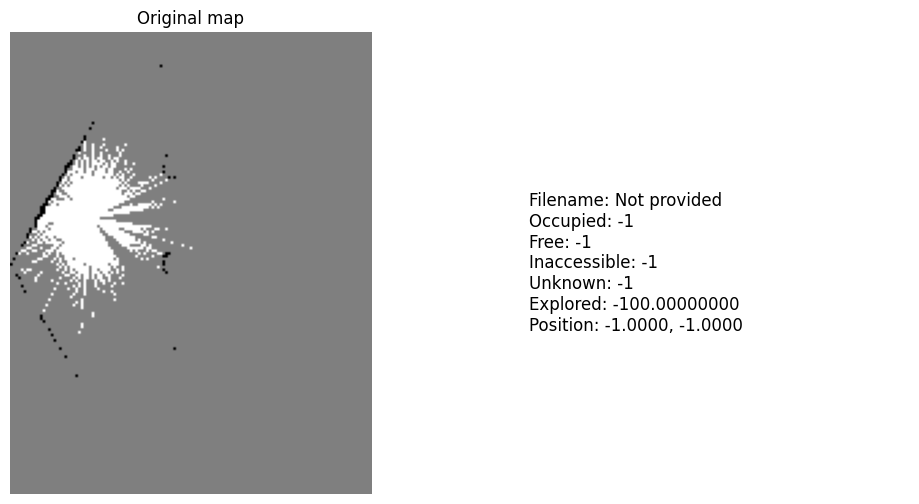

Marking position at world coordinates: (30, 68)
Marking position at world coordinates: (32, 71)
explored %f not explored %f 0.05674480318443167 0.9432551968155684


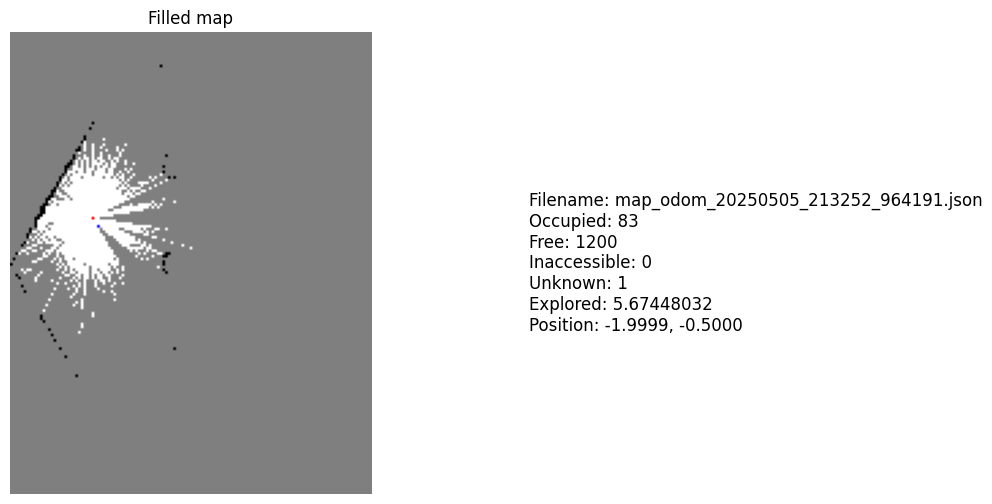

{'header': {'stamp': {'sec': 5, 'nanosec': 328000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 133, 'height': 170, 'origin': {'position': {'x': -2.9276428053780297, 'y': -2.5529621305117147, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

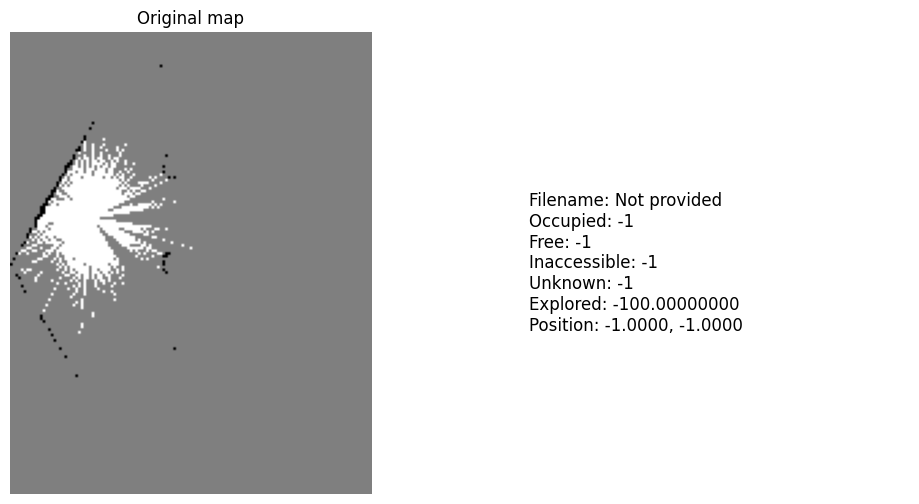

Marking position at world coordinates: (30, 68)
Marking position at world coordinates: (32, 71)
explored %f not explored %f 0.05674480318443167 0.9432551968155684


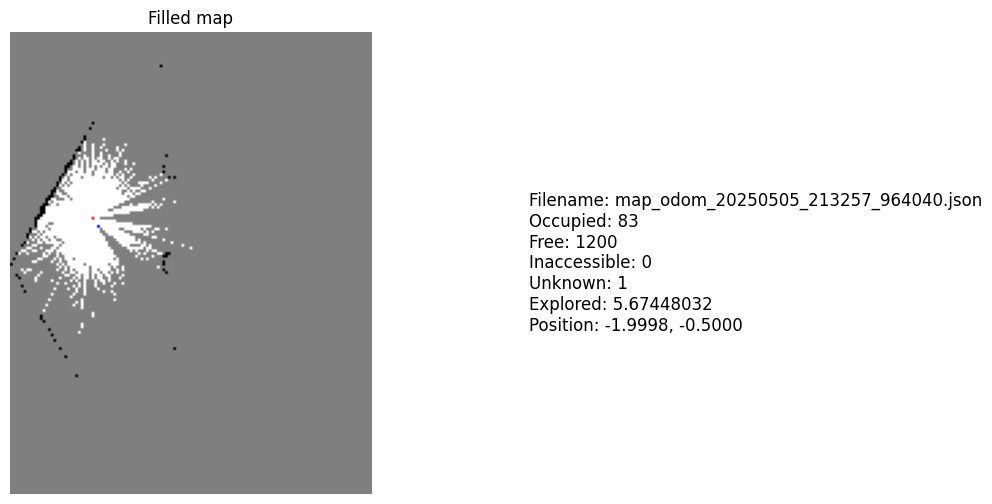

{'header': {'stamp': {'sec': 8, 'nanosec': 334000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 133, 'height': 170, 'origin': {'position': {'x': -2.9276428053780297, 'y': -2.5529621305117147, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

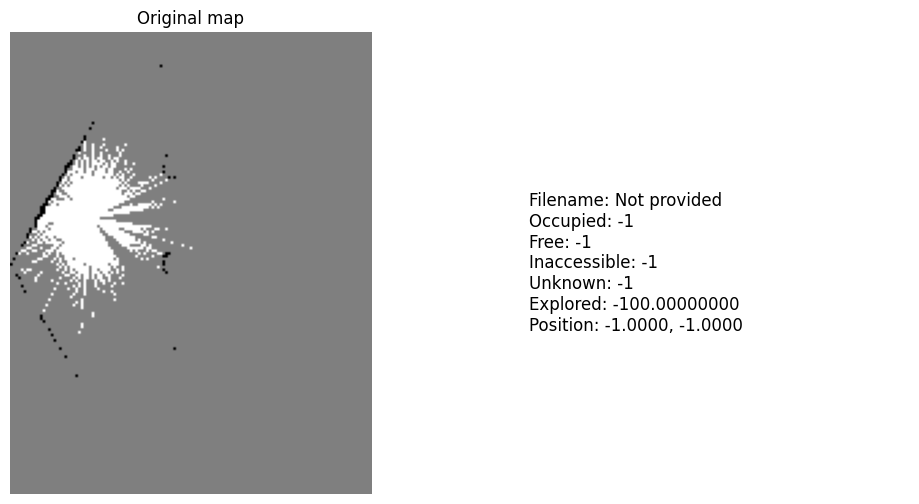

Marking position at world coordinates: (30, 68)
Marking position at world coordinates: (32, 71)
explored %f not explored %f 0.05674480318443167 0.9432551968155684


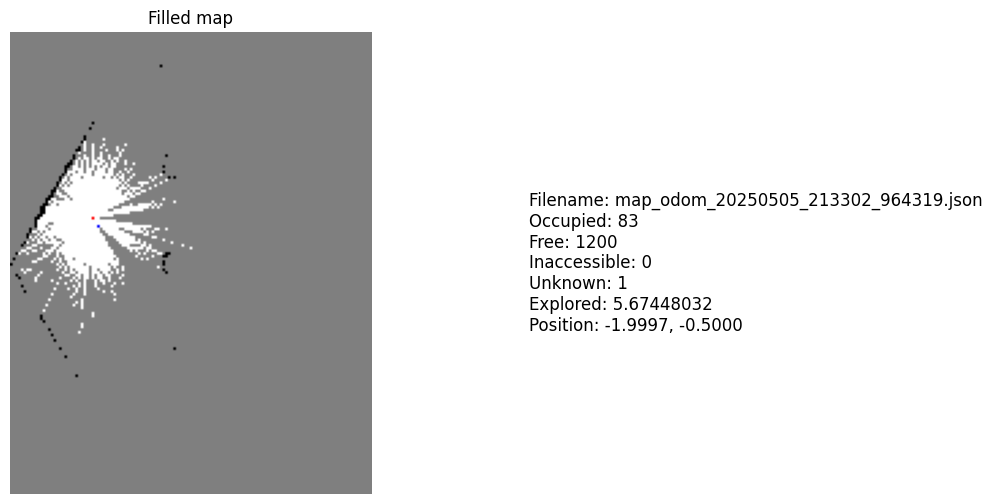

{'header': {'stamp': {'sec': 11, 'nanosec': 739000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 145, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.5529621305117147, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

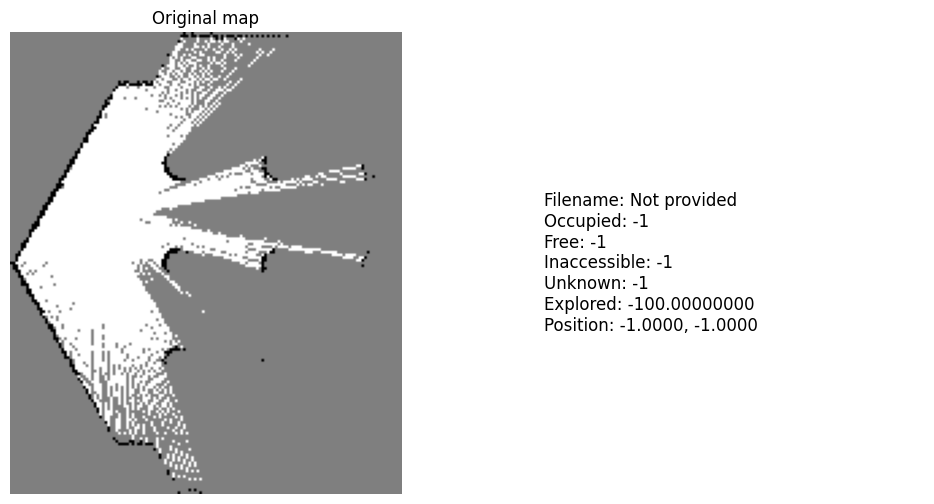

Marking position at world coordinates: (40, 62)
Marking position at world coordinates: (48, 69)
explored %f not explored %f 0.23456342004436379 0.7654365799556362


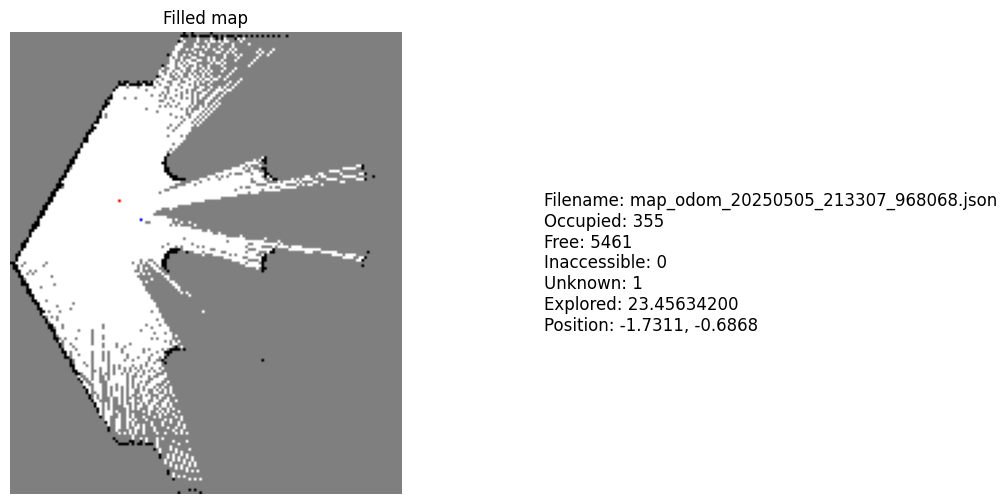

{'header': {'stamp': {'sec': 14, 'nanosec': 755000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 145, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.5529621305117147, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

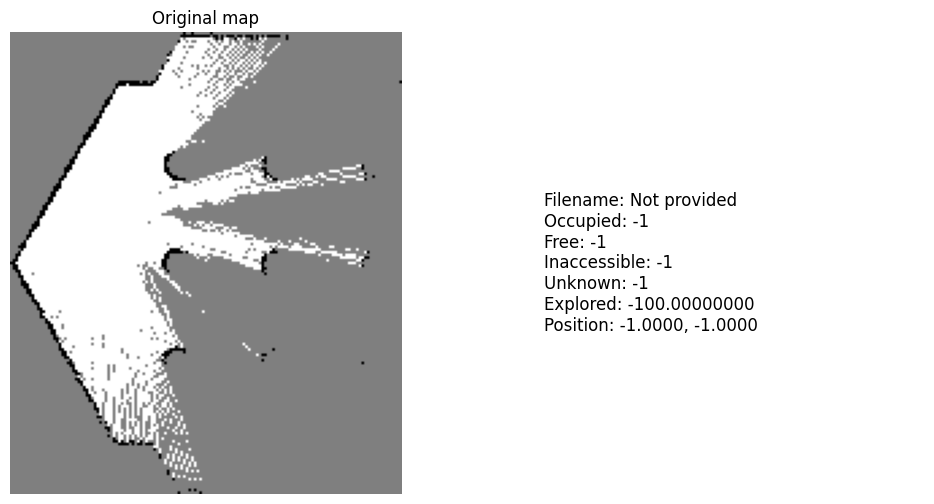

Marking position at world coordinates: (50, 37)
Marking position at world coordinates: (59, 46)
explored %f not explored %f 0.27017543859649124 0.7298245614035088


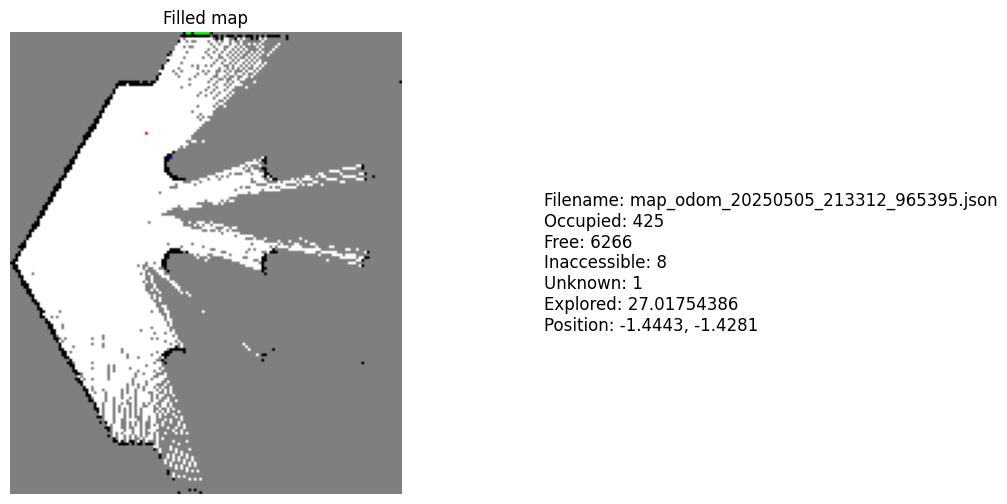

{'header': {'stamp': {'sec': 17, 'nanosec': 777000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 170, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.5529621305117147, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, 100, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

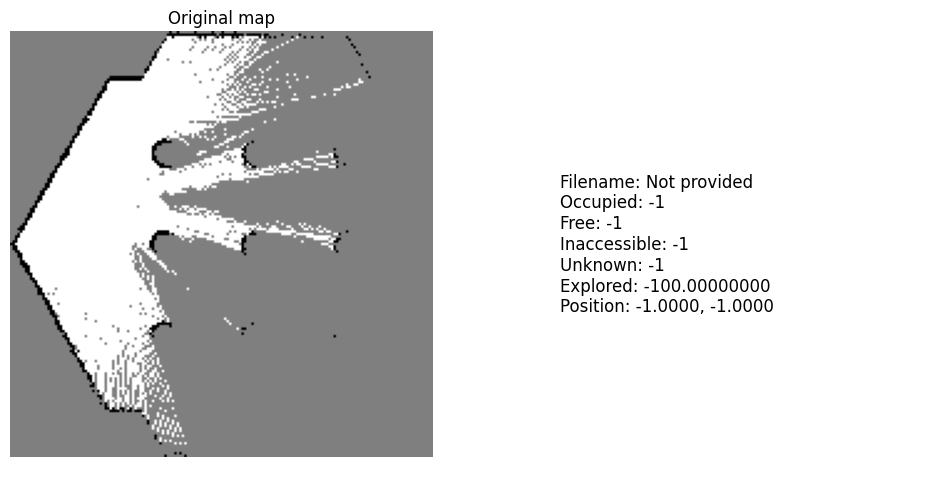

Marking position at world coordinates: (65, 21)
Marking position at world coordinates: (74, 17)
explored %f not explored %f 0.2565531475748194 0.7434468524251806


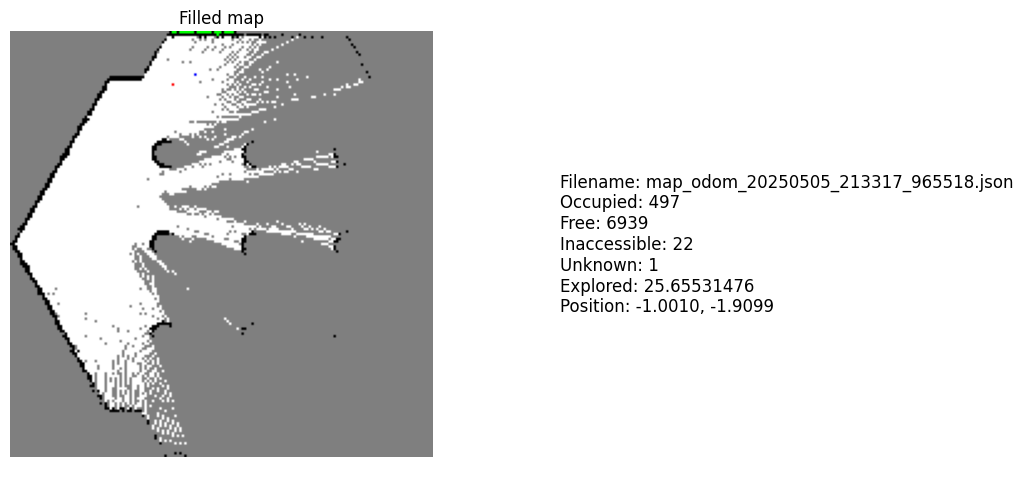

{'header': {'stamp': {'sec': 20, 'nanosec': 795000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 180, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.5606957701973174, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

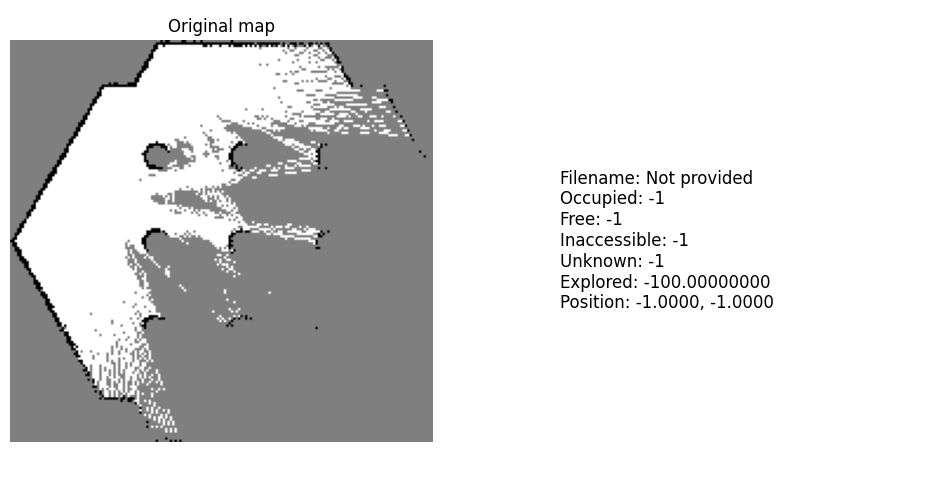

Marking position at world coordinates: (89, 20)
Marking position at world coordinates: (88, 32)
explored %f not explored %f 0.3891163092917479 0.6108836907082521


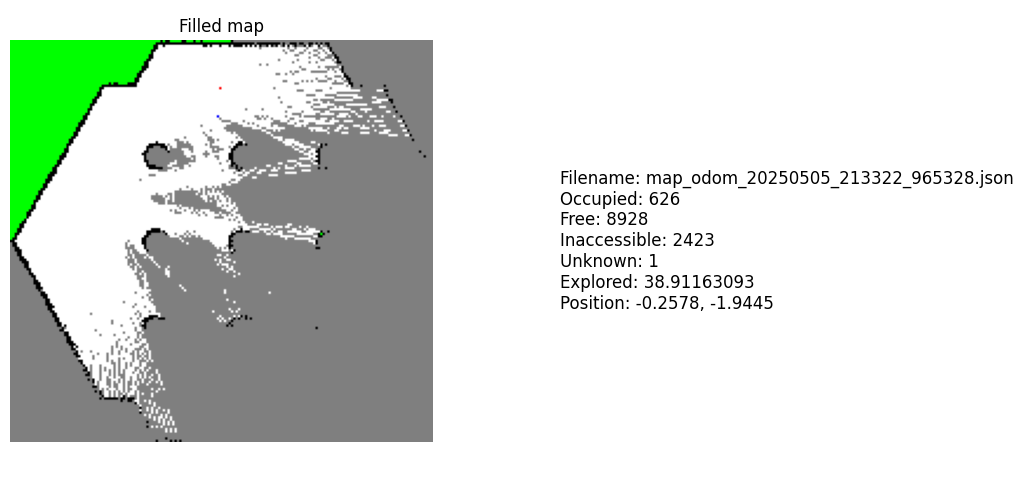

{'header': {'stamp': {'sec': 24, 'nanosec': 25000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 187, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, -1, 100, -1, -1, 100, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

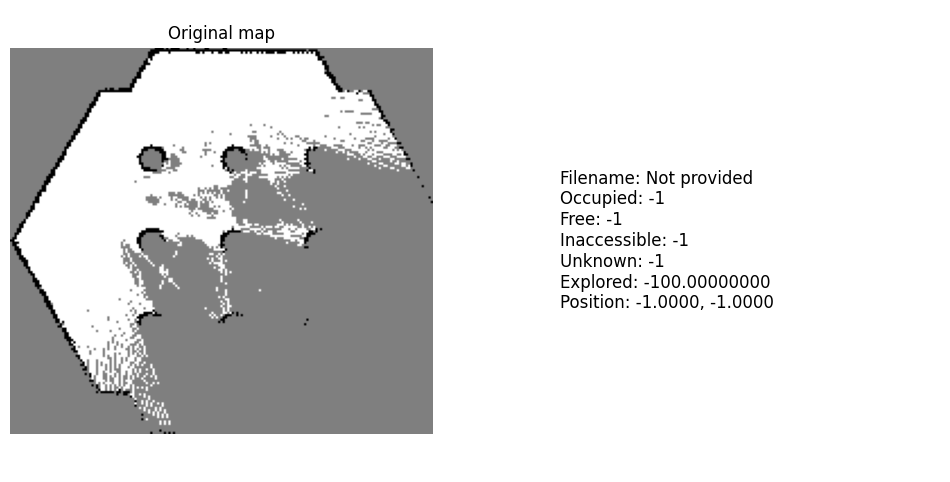

Marking position at world coordinates: (115, 23)
Marking position at world coordinates: (115, 35)
explored %f not explored %f 0.42105263157894735 0.5789473684210527


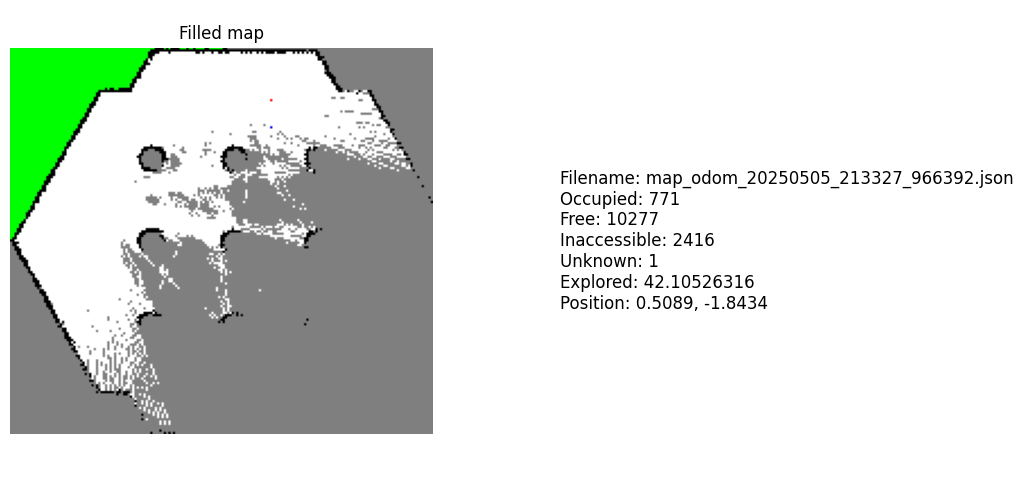

{'header': {'stamp': {'sec': 26, 'nanosec': 849000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 187, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

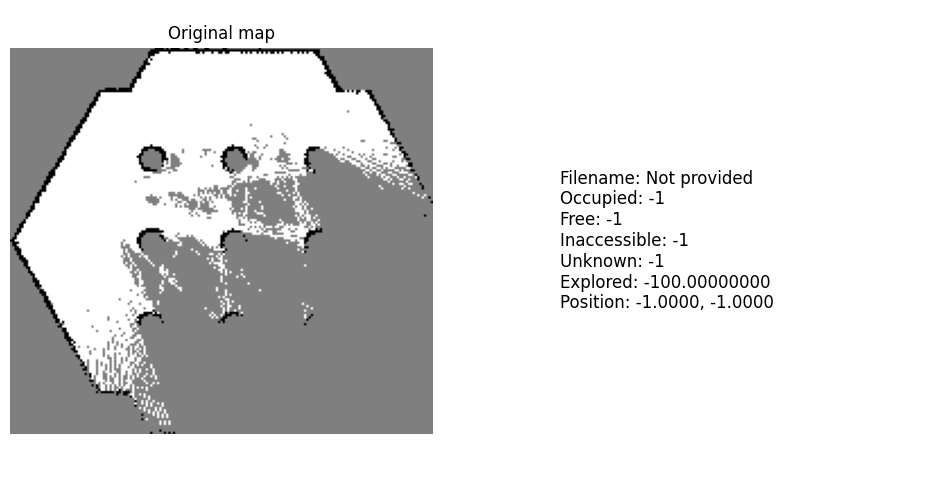

Marking position at world coordinates: (137, 30)
Marking position at world coordinates: (149, 28)
explored %f not explored %f 0.4405041123307377 0.5594958876692623


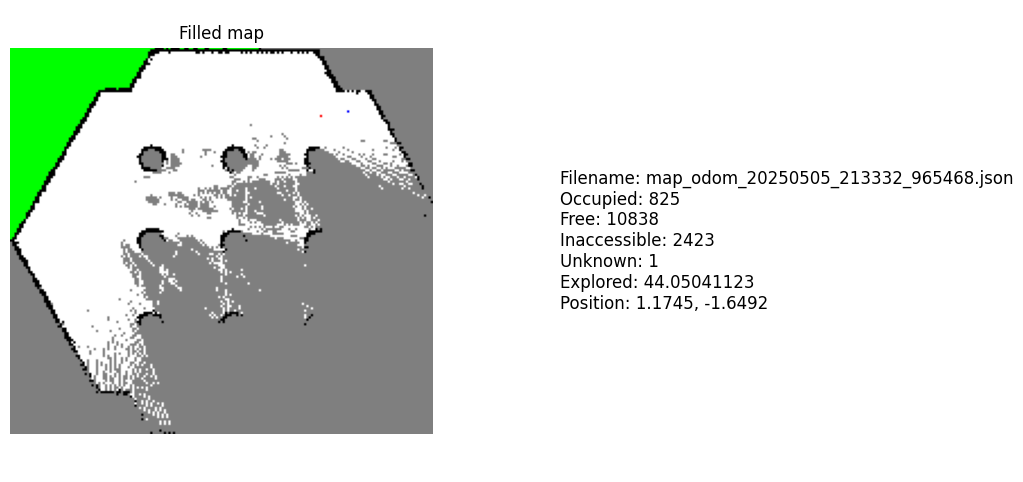

{'header': {'stamp': {'sec': 29, 'nanosec': 673000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

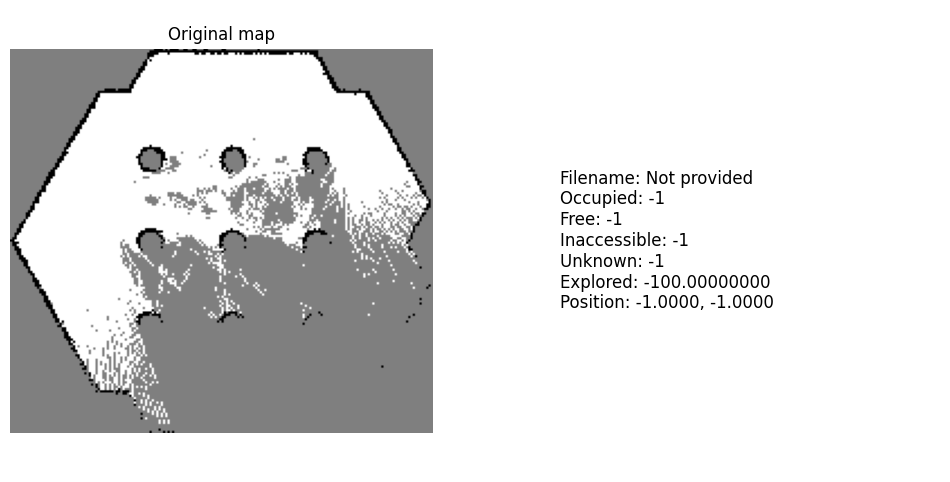

Marking position at world coordinates: (154, 47)
Marking position at world coordinates: (144, 53)
explored %f not explored %f 0.4817095931317656 0.5182904068682344


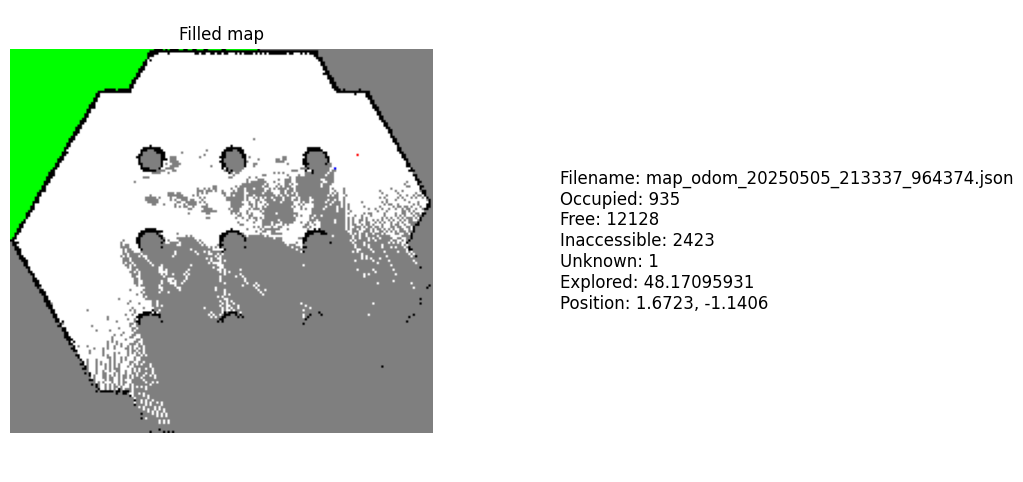

{'header': {'stamp': {'sec': 32, 'nanosec': 886000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 171, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

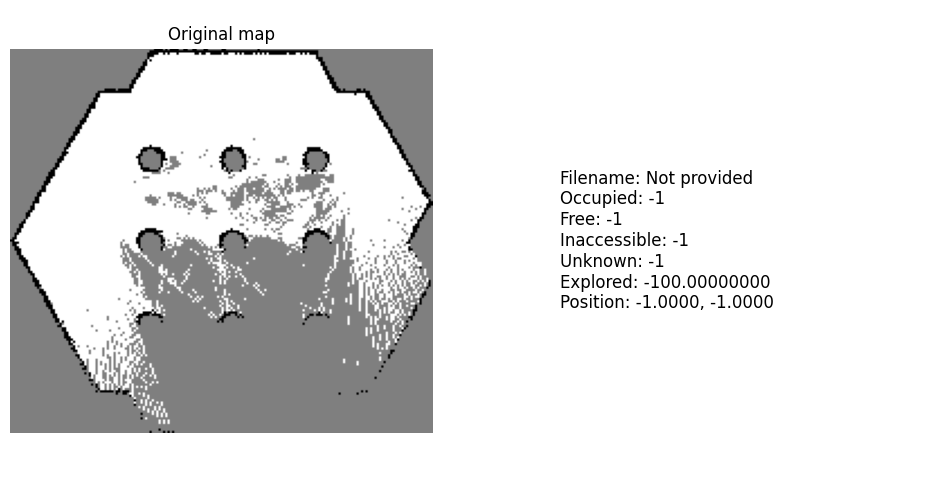

Marking position at world coordinates: (158, 72)
Marking position at world coordinates: (168, 76)
explored %f not explored %f 0.5765521960930695 0.4234478039069305


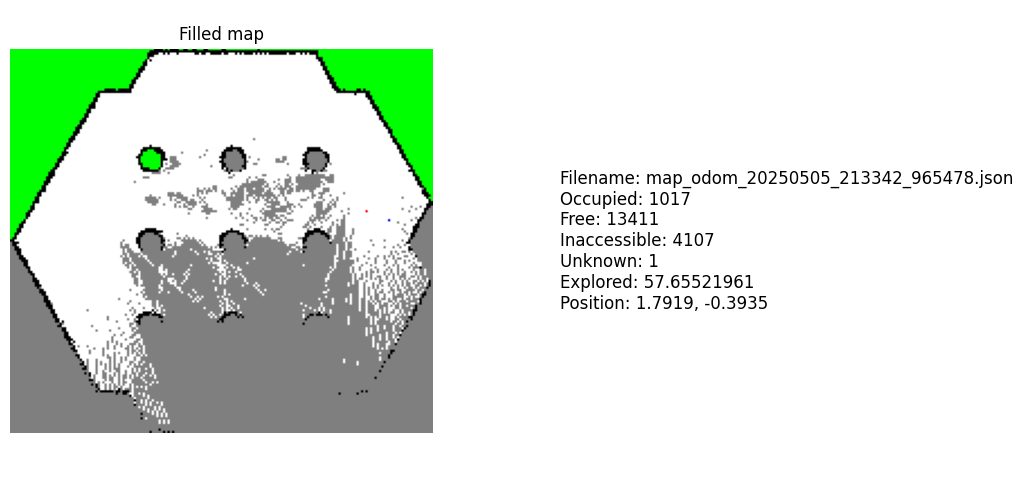

{'header': {'stamp': {'sec': 35, 'nanosec': 893000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 172, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

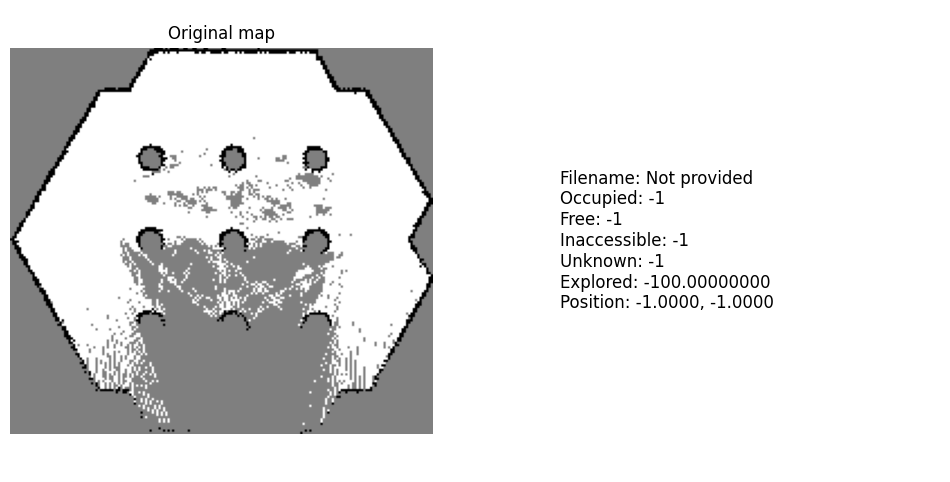

Marking position at world coordinates: (158, 97)
Marking position at world coordinates: (149, 99)
explored %f not explored %f 0.6446375556655122 0.3553624443344878


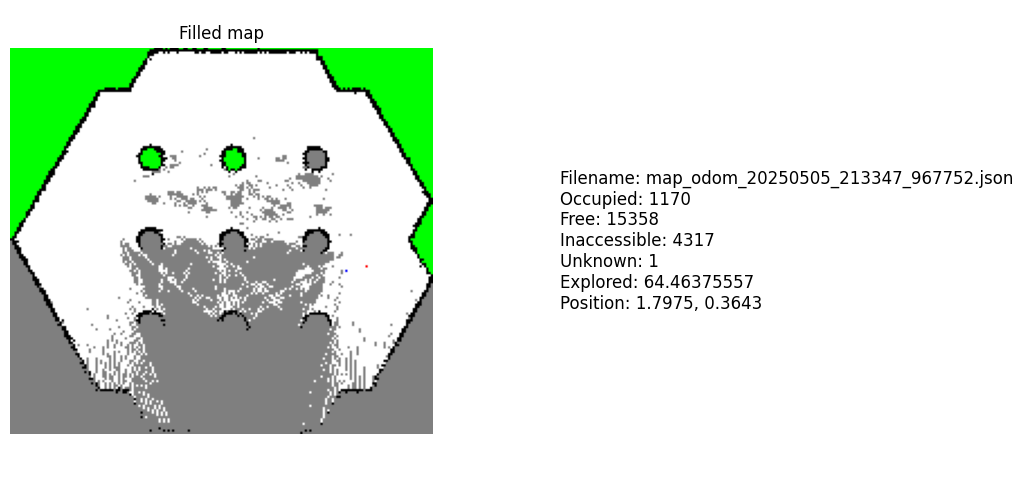

{'header': {'stamp': {'sec': 38, 'nanosec': 911000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 172, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

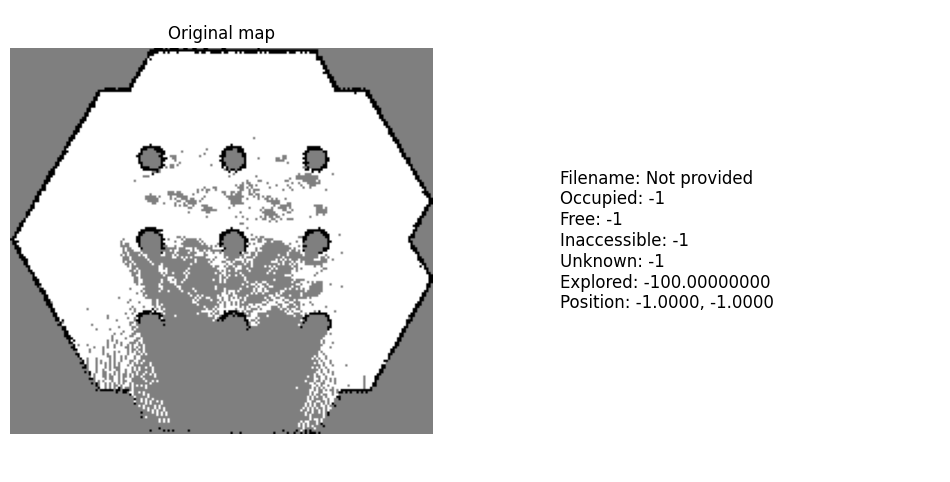

Marking position at world coordinates: (156, 117)
Marking position at world coordinates: (144, 117)
explored %f not explored %f 0.6676768926274121 0.33232310737258786


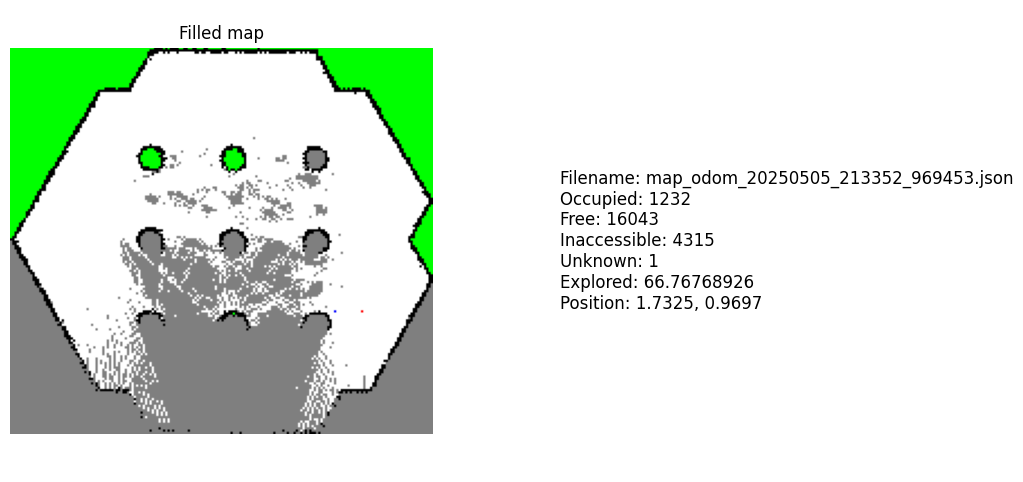

{'header': {'stamp': {'sec': 41, 'nanosec': 925000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 178, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

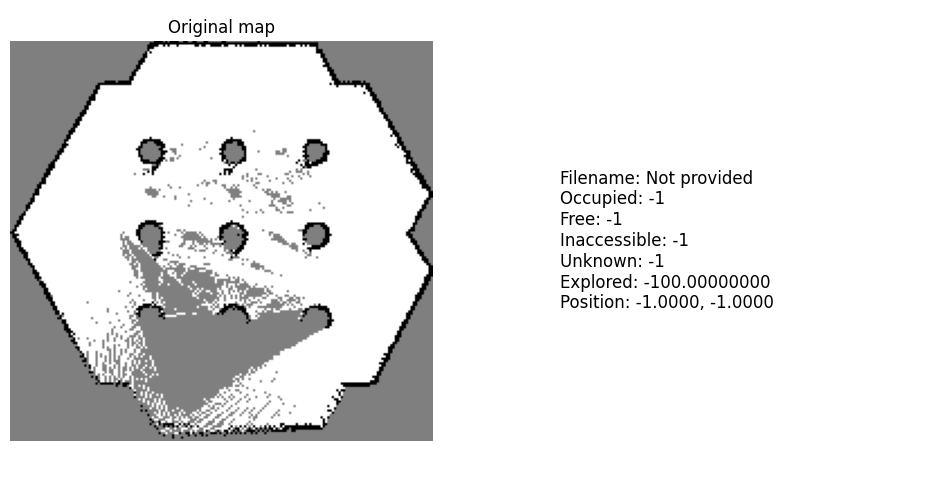

Marking position at world coordinates: (149, 121)
Marking position at world coordinates: (141, 123)
explored %f not explored %f 0.7245099211092517 0.2754900788907483


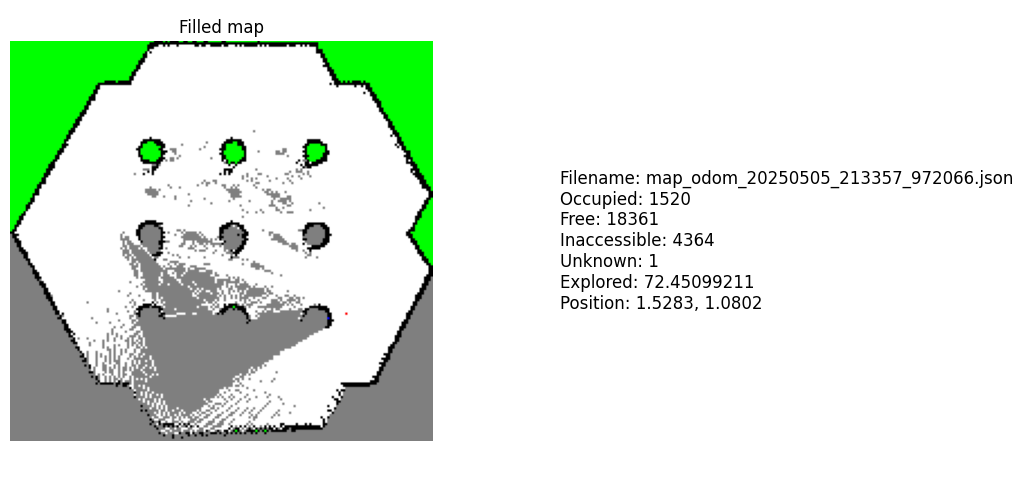

{'header': {'stamp': {'sec': 44, 'nanosec': 749000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 178, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

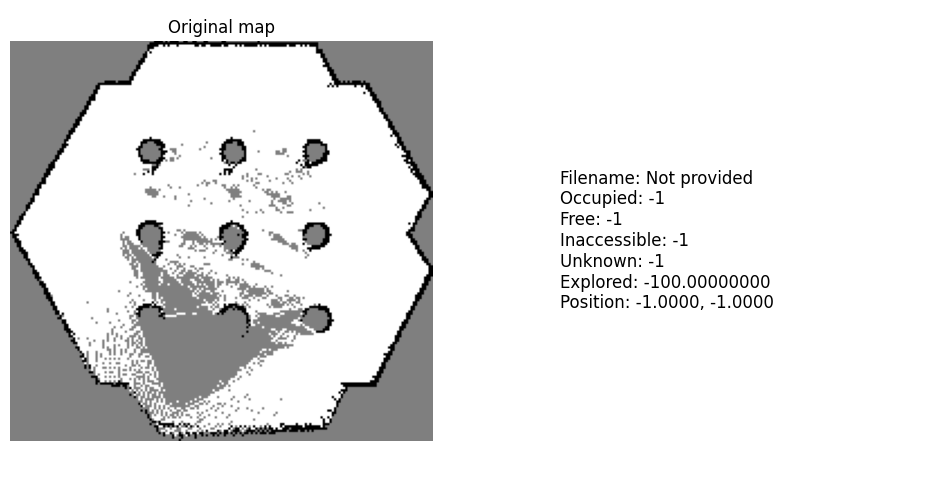

Marking position at world coordinates: (137, 138)
Marking position at world coordinates: (134, 130)
explored %f not explored %f 0.7432763566818074 0.25672364331819264


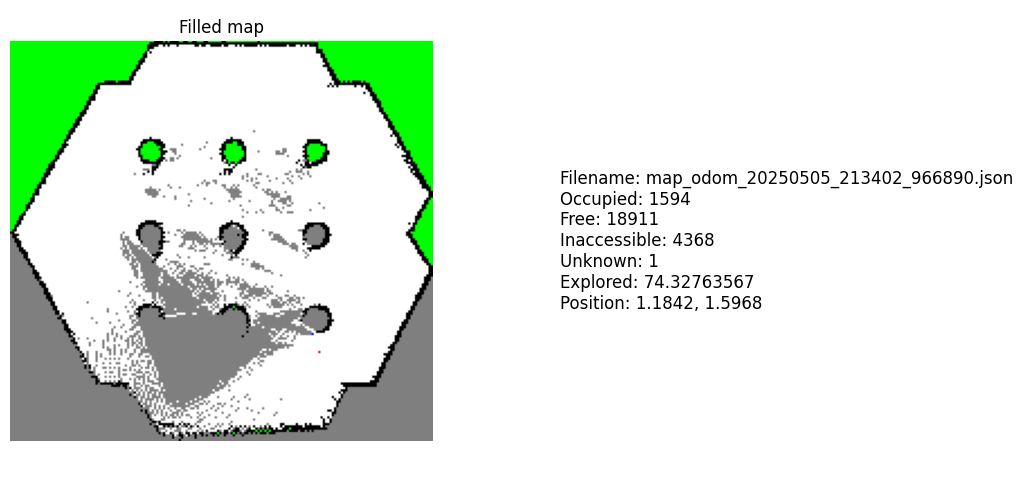

{'header': {'stamp': {'sec': 47, 'nanosec': 768000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 178, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

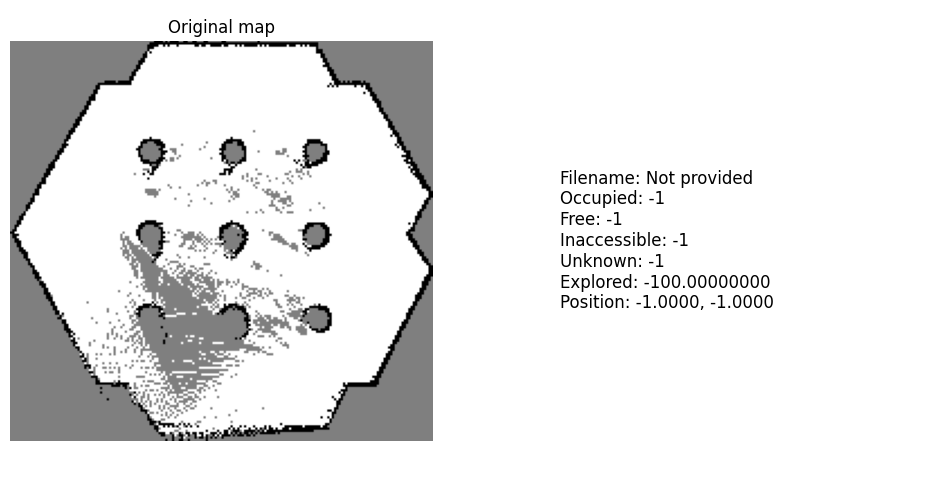

Marking position at world coordinates: (113, 146)
Marking position at world coordinates: (115, 139)
explored %f not explored %f 0.7710375328711451 0.22896246712885493


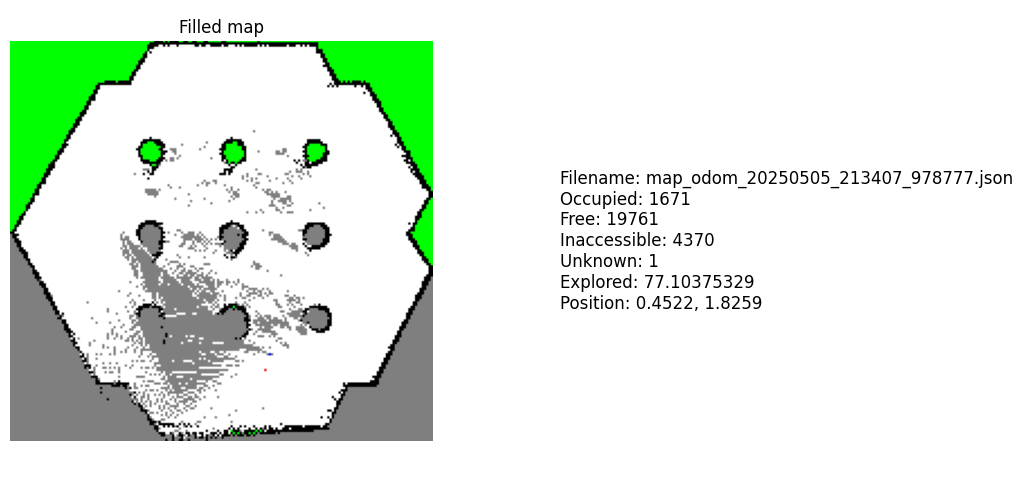

{'header': {'stamp': {'sec': 50, 'nanosec': 577000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 180, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

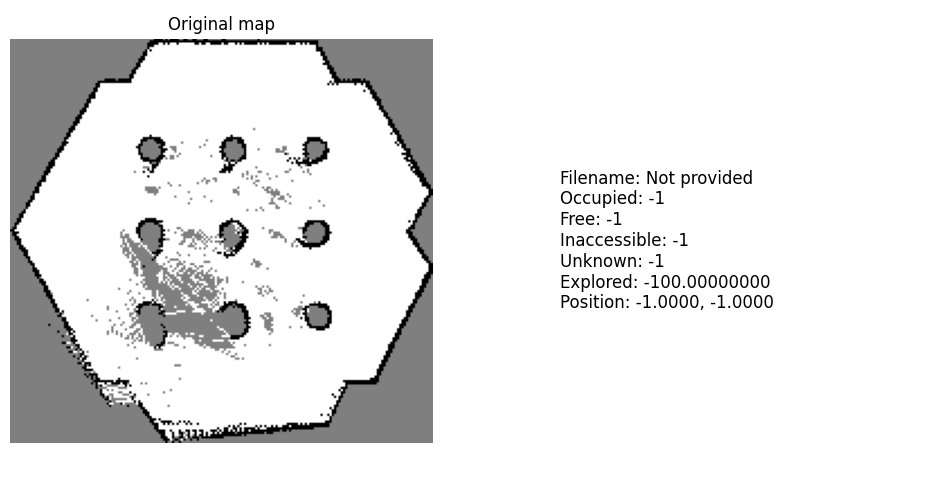

Marking position at world coordinates: (103, 151)
Marking position at world coordinates: (103, 142)
explored %f not explored %f 0.8019799054373522 0.1980200945626478


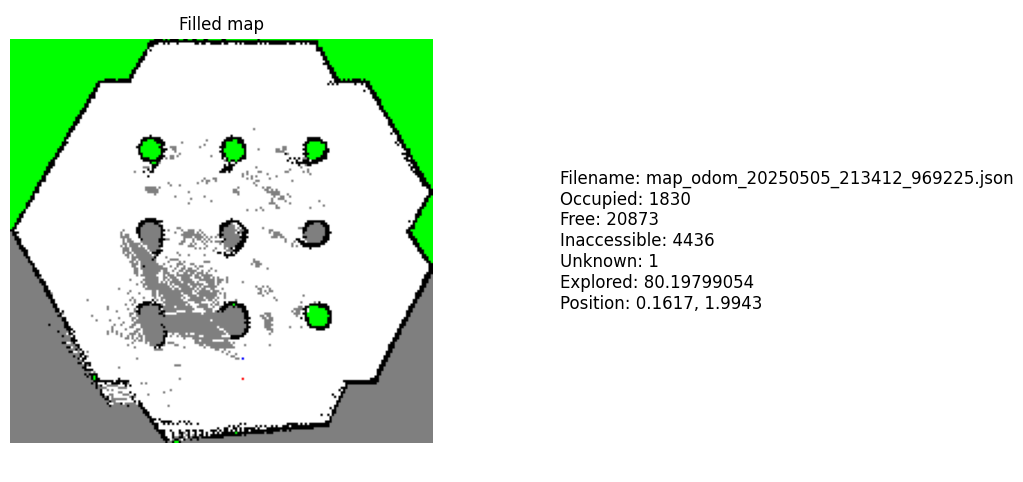

{'header': {'stamp': {'sec': 53, 'nanosec': 787000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 180, 'origin': {'position': {'x': -2.9536774383841924, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

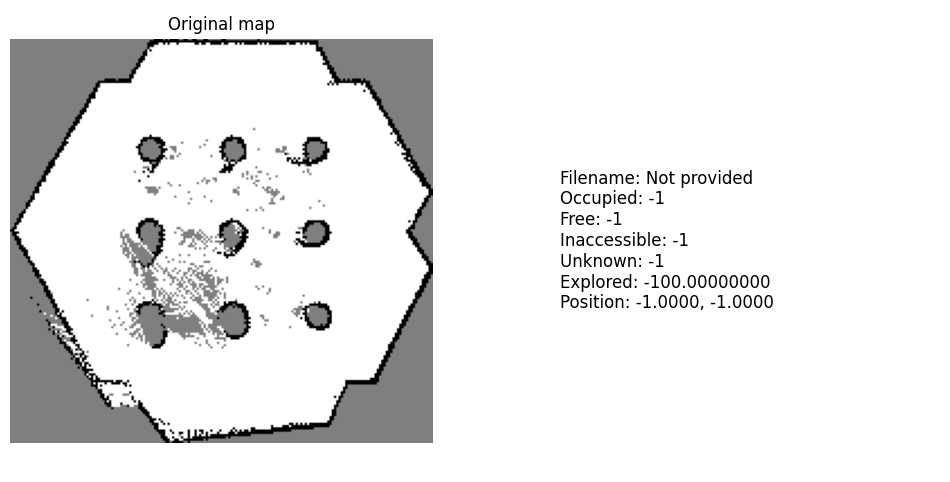

Marking position at world coordinates: (78, 145)
Marking position at world coordinates: (84, 136)
explored %f not explored %f 0.8787529550827423 0.12124704491725768


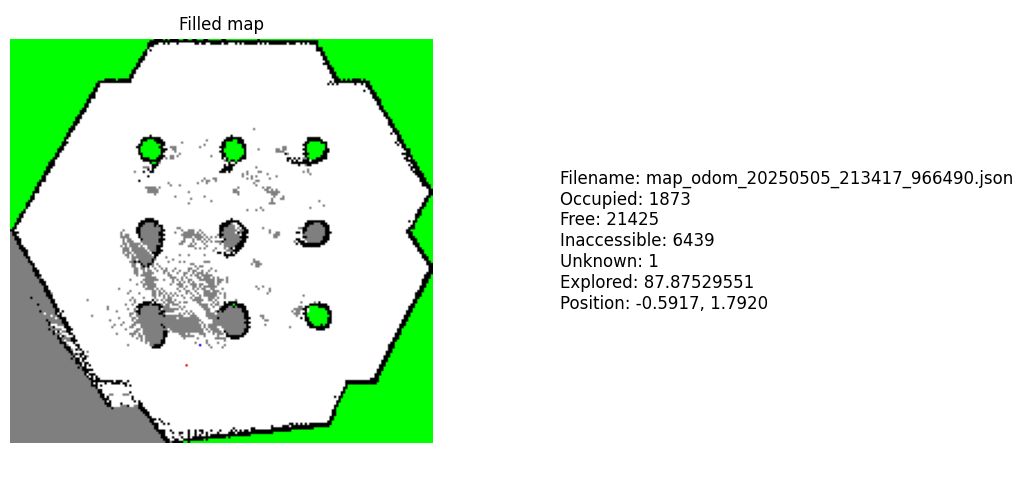

{'header': {'stamp': {'sec': 56, 'nanosec': 792000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 190, 'height': 180, 'origin': {'position': {'x': -3.015080931134698, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

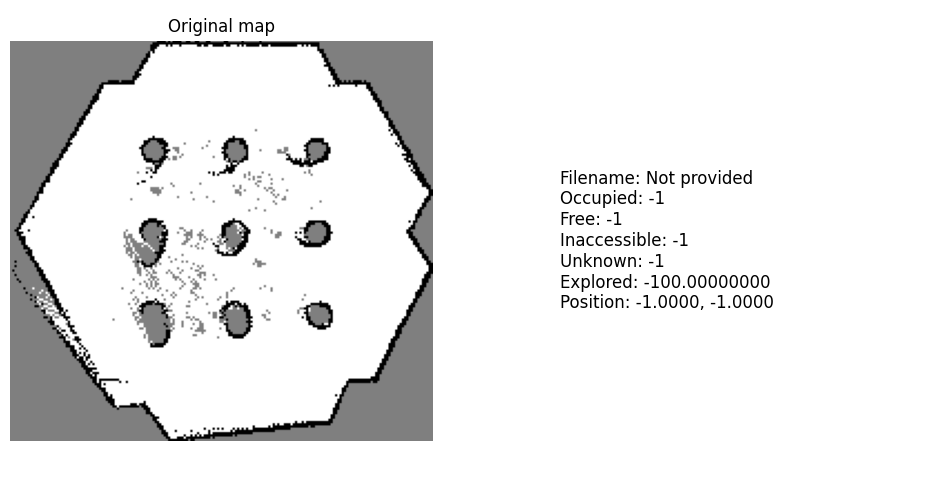

Marking position at world coordinates: (57, 135)
Marking position at world coordinates: (62, 135)
explored %f not explored %f 0.8169590643274853 0.18304093567251467


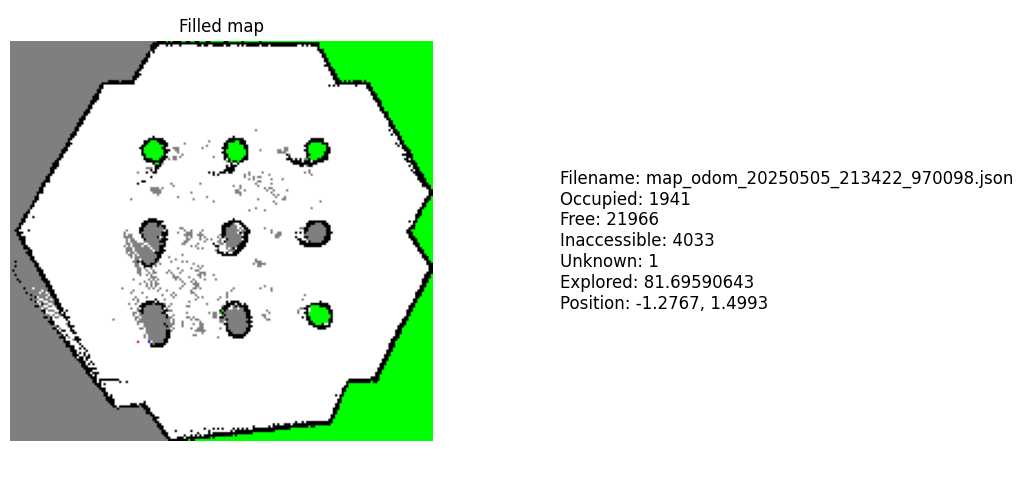

{'header': {'stamp': {'sec': 59, 'nanosec': 605000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 190, 'height': 181, 'origin': {'position': {'x': -3.015080931134698, 'y': -2.561294616480672, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 100, -1, 100, -1, 100, 100, 100, 100, -1, -1, 100, 100, -1, -1, 100, 100, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, 100, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

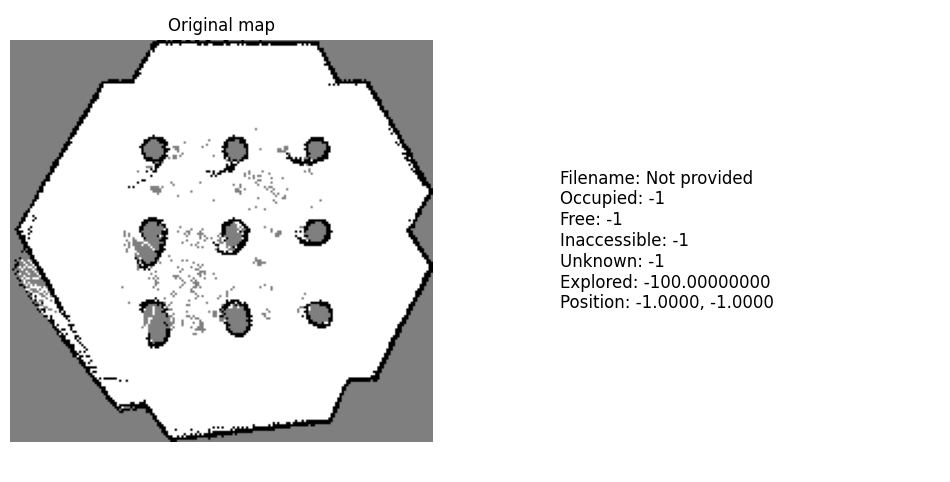

Marking position at world coordinates: (44, 117)
Marking position at world coordinates: (53, 118)
explored %f not explored %f 0.8234079674323931 0.17659203256760692


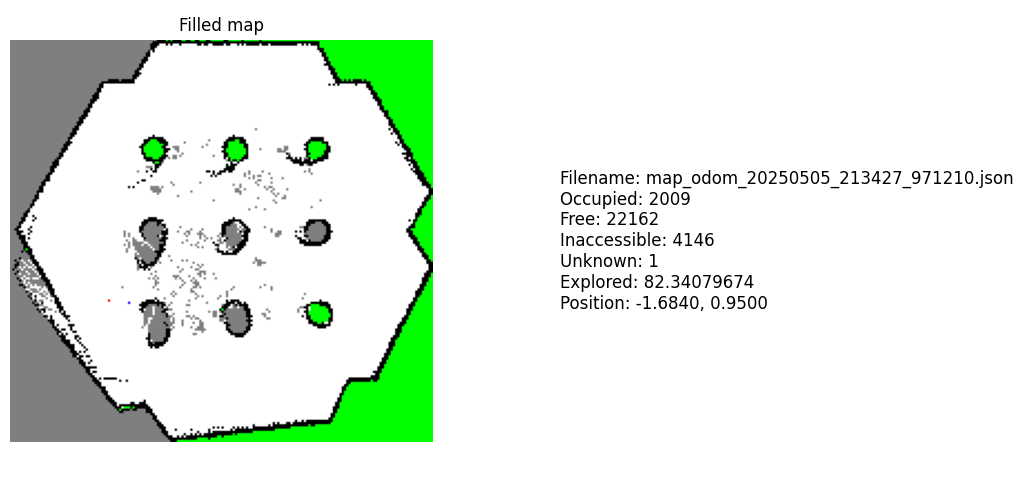

{'header': {'stamp': {'sec': 62, 'nanosec': 417000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 187, 'height': 174, 'origin': {'position': {'x': -2.9626397491207124, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

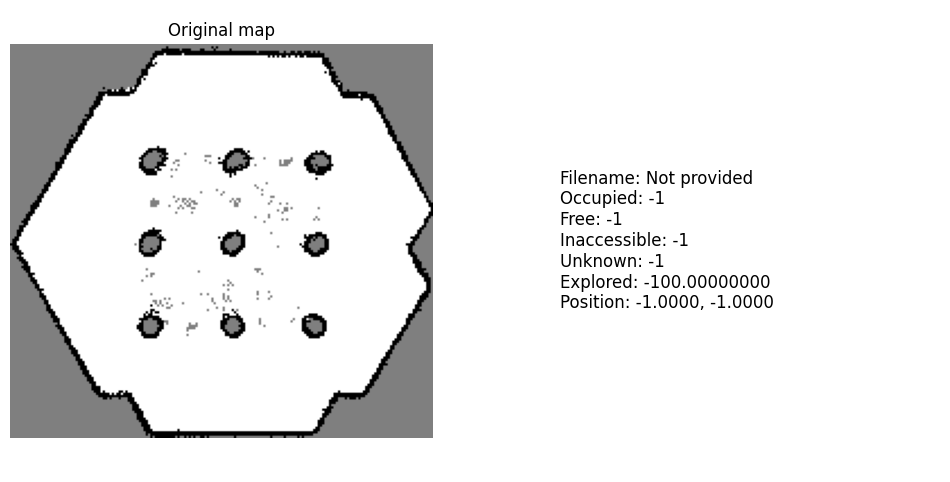

Marking position at world coordinates: (42, 110)
Marking position at world coordinates: (58, 104)
explored %f not explored %f 0.9941606736738583 0.005839326326141703


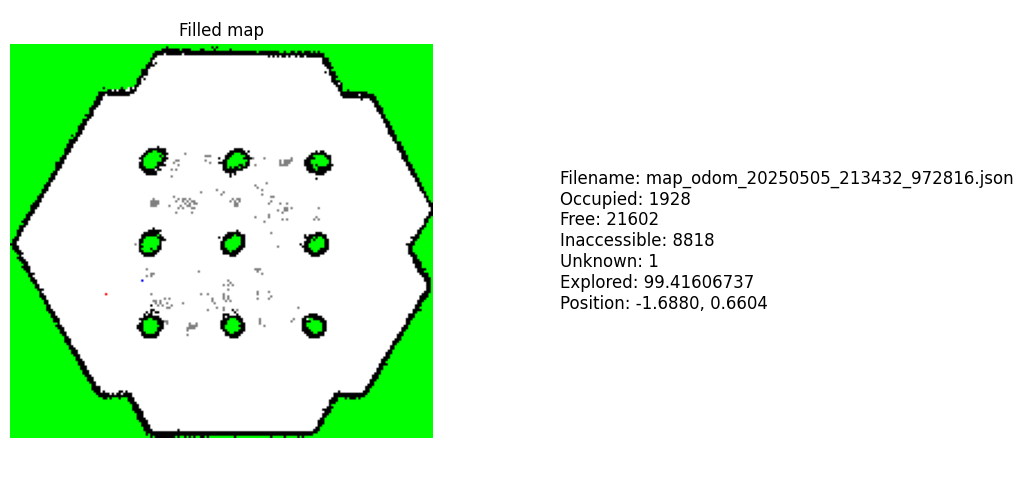

{'header': {'stamp': {'sec': 65, 'nanosec': 431000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 174, 'origin': {'position': {'x': -2.967012748756958, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

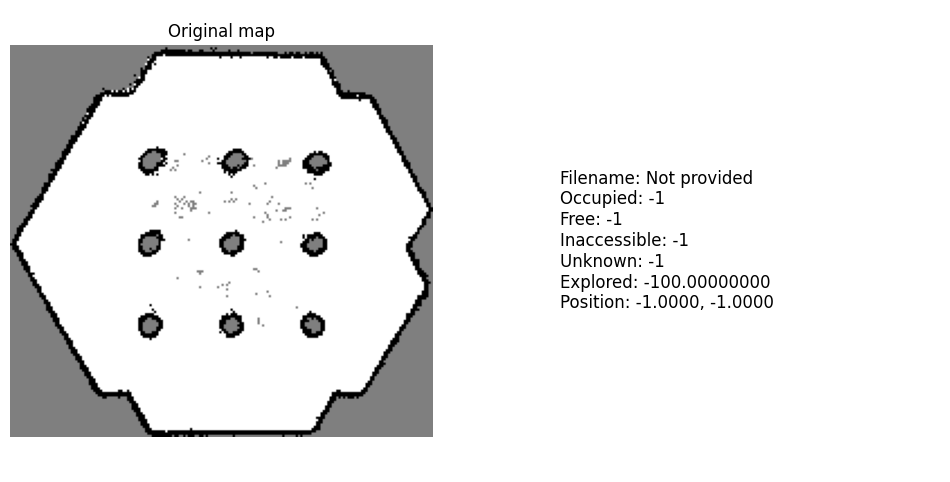

Marking position at world coordinates: (58, 102)
Marking position at world coordinates: (74, 103)
explored %f not explored %f 0.9962399119589141 0.0037600880410858517


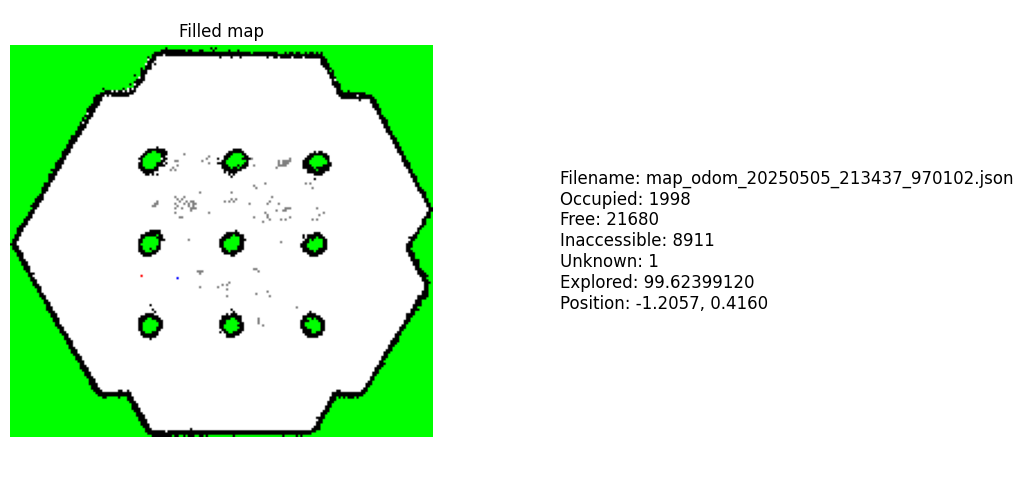

{'header': {'stamp': {'sec': 68, 'nanosec': 249000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 174, 'origin': {'position': {'x': -2.967012748756958, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

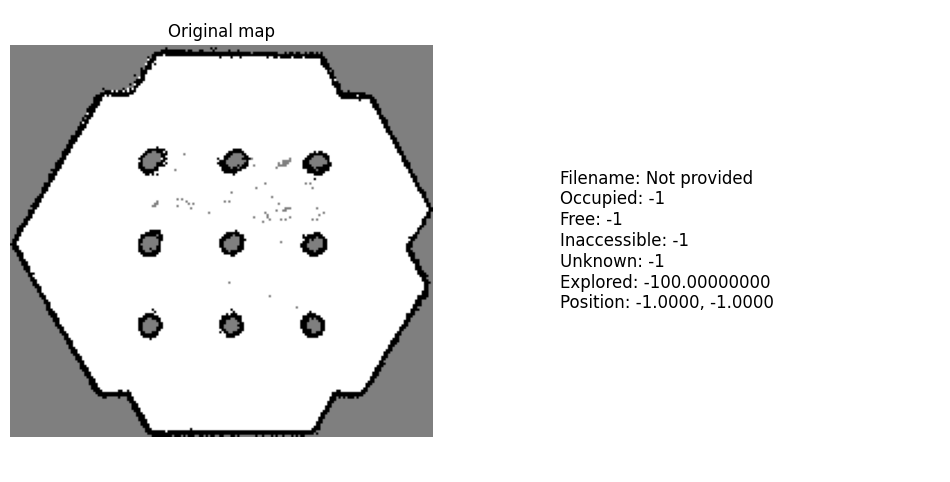

Marking position at world coordinates: (79, 108)
Marking position at world coordinates: (97, 105)
explored %f not explored %f 0.997982391782832 0.00201760821716801


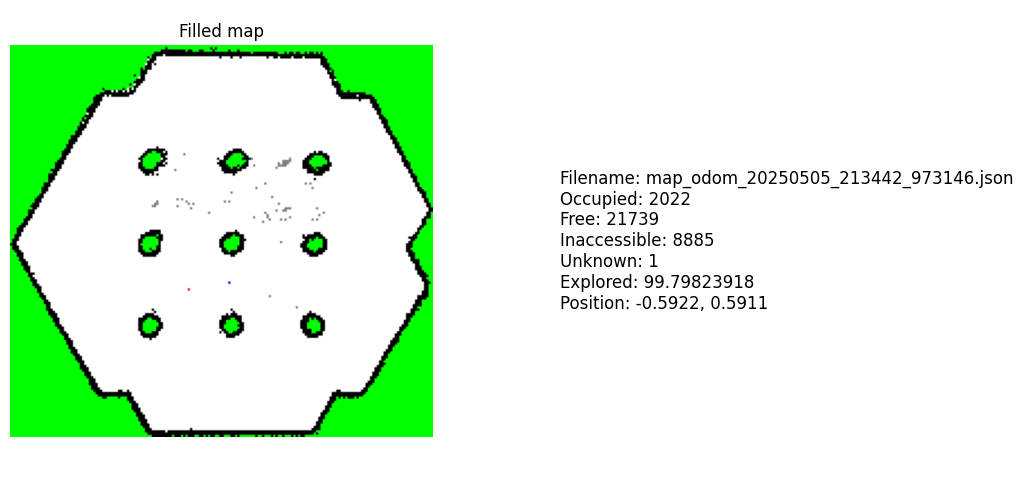

{'header': {'stamp': {'sec': 70, 'nanosec': 853000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 174, 'origin': {'position': {'x': -2.967012748756958, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

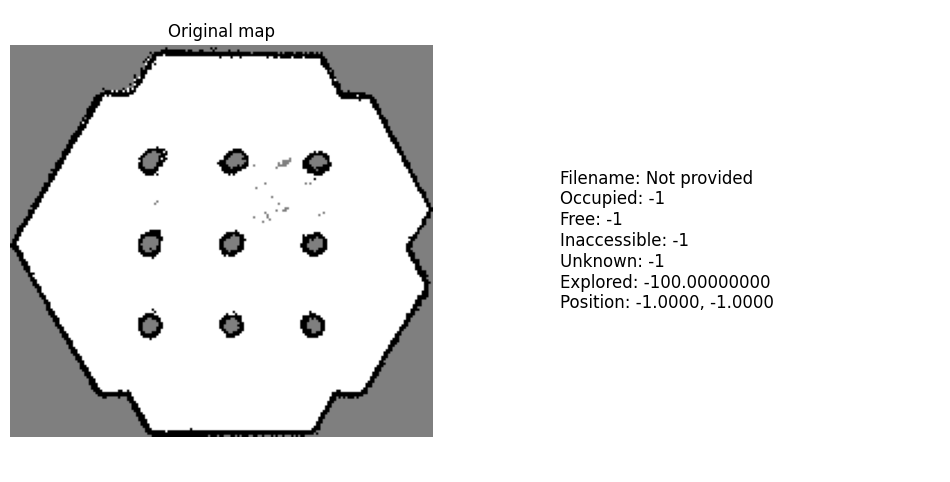

Marking position at world coordinates: (100, 106)
Marking position at world coordinates: (112, 78)
explored %f not explored %f 0.998868916605527 0.001131083394472987


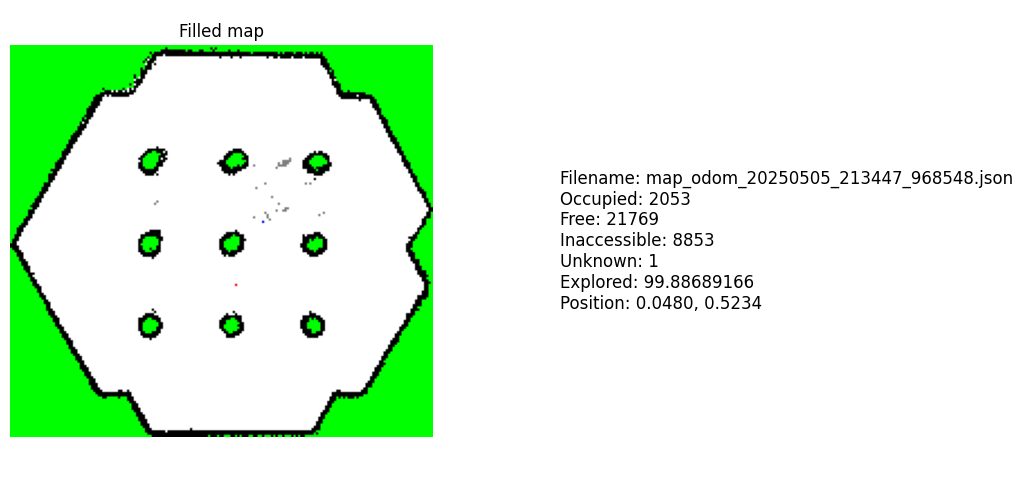

{'header': {'stamp': {'sec': 73, 'nanosec': 863000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 174, 'origin': {'position': {'x': -2.967012748756958, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

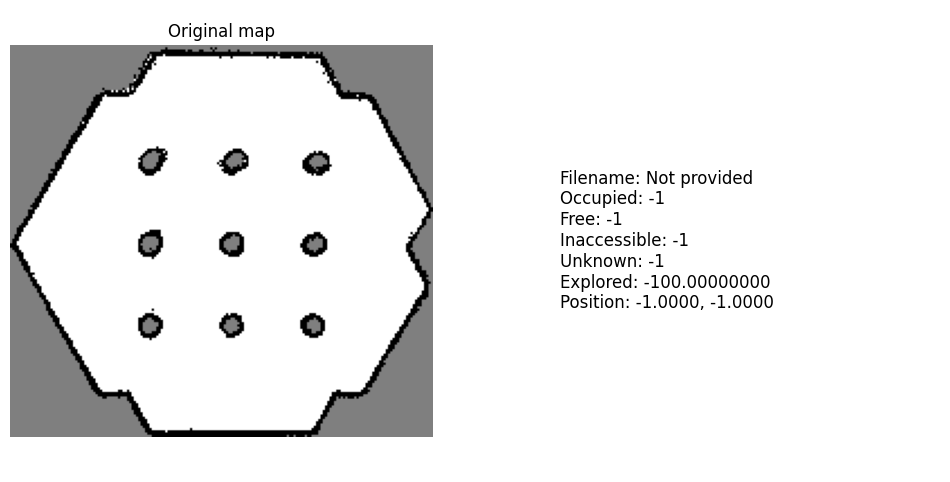

Marking position at world coordinates: (116, 87)
No unknowns found
explored %f not explored %f 0.9999694301785278 3.0569821472203884e-05


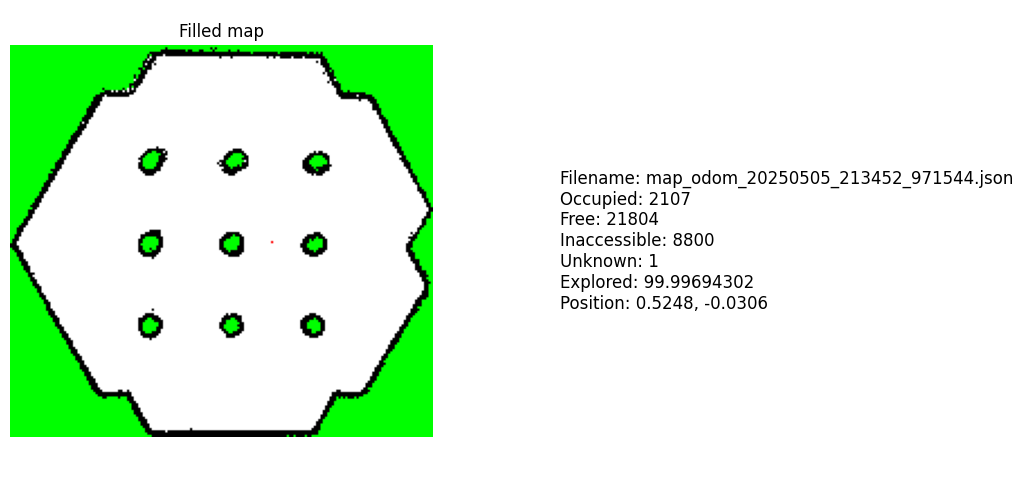

{'header': {'stamp': {'sec': 76, 'nanosec': 675000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 174, 'origin': {'position': {'x': -2.967012748756958, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

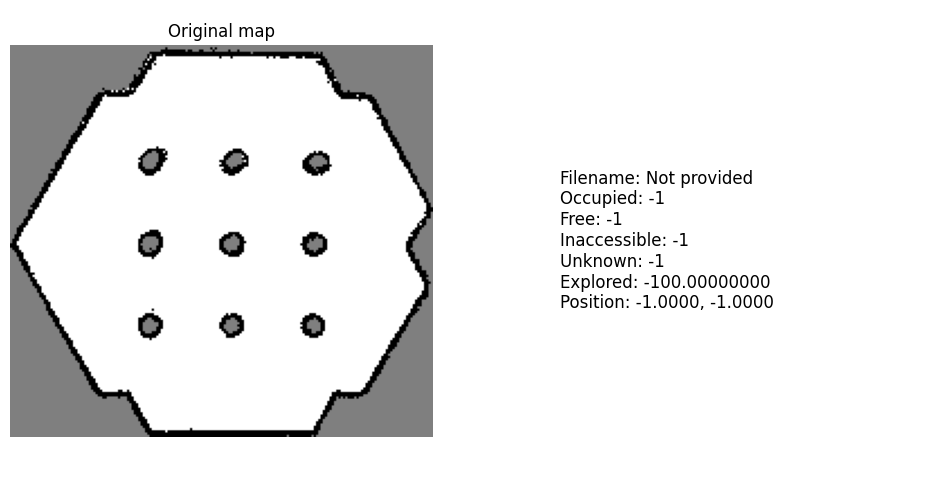

Marking position at world coordinates: (102, 70)
No unknowns found
explored %f not explored %f 0.9999694301785278 3.0569821472203884e-05


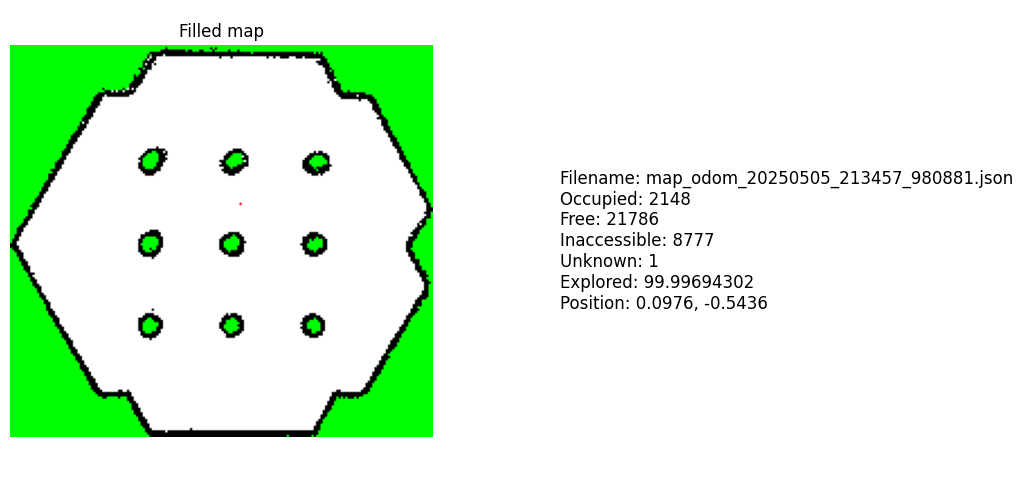

{'header': {'stamp': {'sec': 79, 'nanosec': 88000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 188, 'height': 174, 'origin': {'position': {'x': -2.9737276014344483, 'y': -2.6577183216049107, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

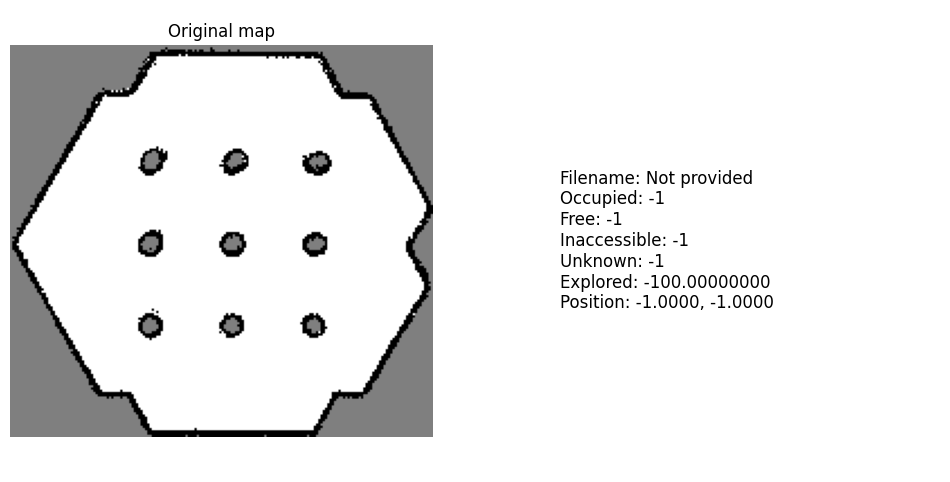

Marking position at world coordinates: (83, 68)
No unknowns found
explored %f not explored %f 0.9999694301785278 3.0569821472203884e-05


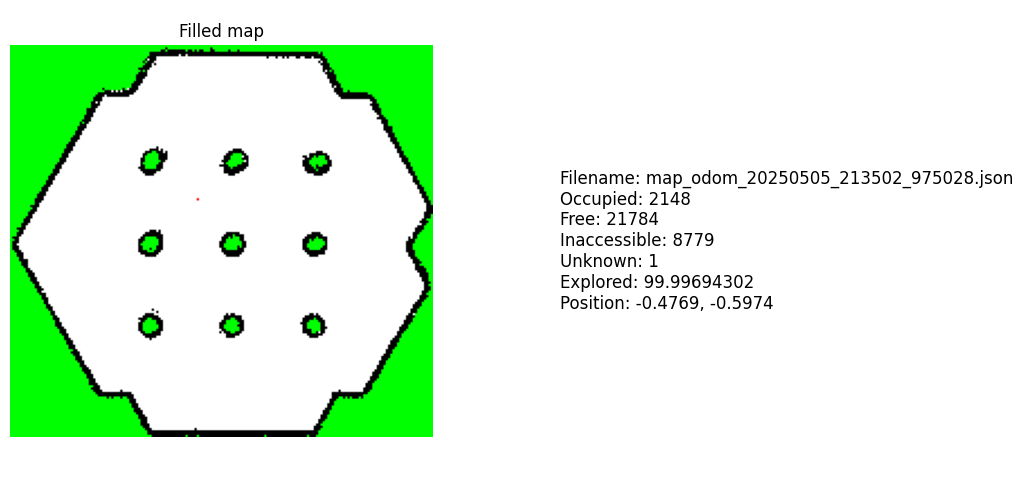

In [16]:
filenames = [_f.name for _f in os.scandir(DIRPATH) if _f.is_file()]
filenames.sort()

for _f in filenames:
    # print(_f)
    _grid, origin_x, origin_y = read_data_map(DIRPATH, _f)
    pos_x, pos_y = read_data_odom(DIRPATH, _f)
    position = get_position(pos_x, pos_y, origin_x, origin_y)

    print_plot_v2(_grid, title="Original map")
    
    filled_grid = fill_enclosed_unknowns_v2(_grid, position)
    fully_enclosed = is_fully_enclosed(filled_grid, position)
    # print(fully_enclosed, _f)
    if fully_enclosed:
        filled_grid = fill_outside_with_val_inaccessible(filled_grid, position)
    
    # filled_grid = mark_position(filled_grid, pos_x, pos_y, origin_x, origin_y)
    
    filled_grid = mark_position_v2(filled_grid, position[0], position[1], VAL_CURR_POSITION)
    _,_, goal_x, goal_y = explore_nearest_unknown(filled_grid, position[0], position[1], origin_x, origin_y)
    if goal_x is not None and goal_y is not None:
        filled_grid = mark_position_v2(filled_grid, goal_x, goal_y, VAL_NEXT_GOAL)
    else:
        print("No unknowns found")
    
    occupied,\
    free,\
    inaccessible,\
    unknown,\
    explored_percent = calculate_remaining_space(filled_grid)
    print_plot_v2(
        filled_grid,
        title=f"Filled map",
        filename=_f,
        occupied=occupied,
        free=free,
        inaccessible=inaccessible,
        unknown=unknown,
        explored_percent=explored_percent,
        position_x=pos_x,
        position_y=pos_y
    )
    
    # break
    
    # TODO create fucntion to fill outer space / not calculate the remaining outer space